# Building a Recommender System Using LightGCN

In [1]:
import torch

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import pandas as pd

ratings = pd.read_csv('Book Crossing Dataset/Ratings.csv.zip', sep=';', encoding='latin-1')
users = pd.read_csv('Book Crossing Dataset/Users.csv.zip', sep=';', encoding='latin-1')
books = pd.read_csv('Book Crossing Dataset/Books.csv.zip', sep=';', encoding='latin-1')

/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_8423/1748112947.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('Book Crossing Dataset/Users.csv.zip', sep=';', encoding='latin-1')


In [3]:
ratings

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [4]:
users

,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN
...,...,...
278854,278854,NaN
278855,278855,50
278856,278856,NaN
278857,278857,NaN


In [5]:
books

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company
...,...,...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271375,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


Exploring the dataset

Looking at the distribution of the ratings

<Axes: xlabel='Rating', ylabel='count'>

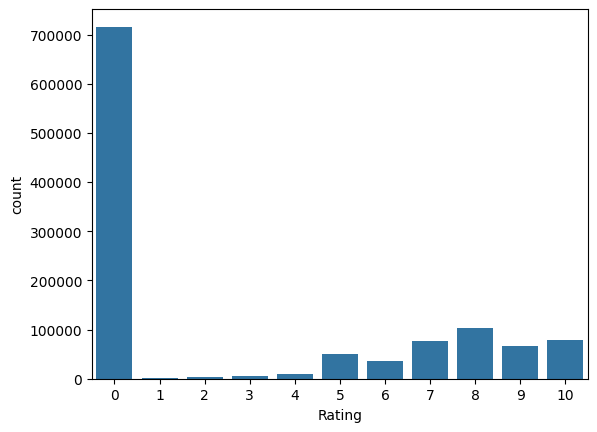

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.countplot(x=ratings['Rating']) 

Comparing then number of unique user IDs vs unique ISBNs

In [7]:
print(len(ratings['User-ID'].unique())) 
print(len(ratings['ISBN'].unique())) 

105283
340556


Visualizing the ISBN counts

Text(0, 0.5, 'Count')

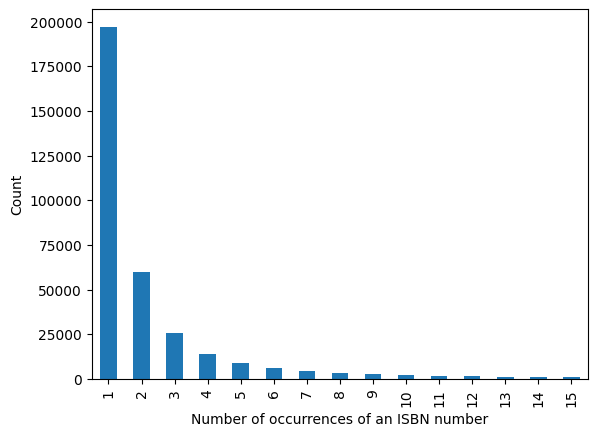

In [8]:
isbn_counts = ratings.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")

Visualizing the User ID counts

Text(0, 0.5, 'Count')

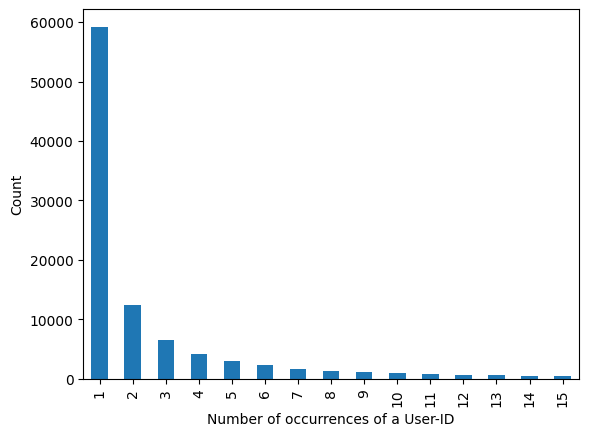

In [9]:
userid_counts = ratings.groupby('User-ID').size() 
count_occurrences = userid_counts.value_counts() 
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")

Preprocessing the Book-Crossing dataset

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [13]:
#Importing the CSV files and removing any values that do not contain an ISBN number or user ID. Keeping the first 100,000 ratings above 8
df = pd.read_csv('Book Crossing Dataset/Ratings.csv.zip', sep=';', encoding='latin-1') 
users = pd.read_csv('Book Crossing Dataset/Users.csv.zip', sep=';', encoding='latin-1') 
books = pd.read_csv('Book Crossing Dataset/Books.csv.zip', sep=';', encoding='latin-1') 

# Preprocessing
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
df = df[df['Rating'] >= 8].iloc[:100000]

/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_8423/748476924.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv('Book Crossing Dataset/Users.csv.zip', sep=';', encoding='latin-1')


In [14]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [65]:
user_mapping

{12: 0,
 16: 1,
 26: 2,
 32: 3,
 39: 4,
 44: 5,
 51: 6,
 53: 7,
 56: 8,
 69: 9,
 70: 10,
 78: 11,
 82: 12,
 87: 13,
 91: 14,
 92: 15,
 99: 16,
 107: 17,
 114: 18,
 125: 19,
 133: 20,
 141: 21,
 165: 22,
 183: 23,
 185: 24,
 212: 25,
 217: 26,
 224: 27,
 226: 28,
 228: 29,
 232: 30,
 242: 31,
 243: 32,
 244: 33,
 254: 34,
 256: 35,
 257: 36,
 272: 37,
 291: 38,
 300: 39,
 313: 40,
 326: 41,
 334: 42,
 337: 43,
 339: 44,
 361: 45,
 367: 46,
 372: 47,
 383: 48,
 387: 49,
 388: 50,
 392: 51,
 408: 52,
 413: 53,
 424: 54,
 430: 55,
 440: 56,
 441: 57,
 444: 58,
 446: 59,
 460: 60,
 463: 61,
 472: 62,
 475: 63,
 476: 64,
 486: 65,
 487: 66,
 493: 67,
 496: 68,
 499: 69,
 500: 70,
 503: 71,
 505: 72,
 507: 73,
 513: 74,
 523: 75,
 530: 76,
 538: 77,
 542: 78,
 558: 79,
 565: 80,
 566: 81,
 567: 82,
 595: 83,
 596: 84,
 619: 85,
 625: 86,
 626: 87,
 638: 88,
 640: 89,
 643: 90,
 651: 91,
 660: 92,
 677: 93,
 683: 94,
 685: 95,
 695: 96,
 707: 97,
 709: 98,
 713: 99,
 726: 100,
 735: 101,
 739:

In [16]:
item_mapping

{'1879384493': 0,
 '0345402871': 1,
 '0446310786': 2,
 '0449005615': 3,
 '0060168013': 4,
 '0553582909': 5,
 '0440223571': 6,
 '0440225701': 7,
 '0156047624': 8,
 '0380715899': 9,
 '0679865691': 10,
 '1853260053': 11,
 '1414035004': 12,
 '0394895894': 13,
 '0966986105': 14,
 '0071416331': 15,
 '0375509038': 16,
 '0316769487': 17,
 '8445071769': 18,
 '8445071777': 19,
 '0312252617': 20,
 '0312261594': 21,
 '0446677450': 22,
 '0553347594': 23,
 '0671621009': 24,
 '0671864769': 25,
 '0446608653': 26,
 '0446612545': 27,
 '0446612618': 28,
 '0451208080': 29,
 '0553584383': 30,
 '0671027360': 31,
 '0679429220': 32,
 '0345372700': 33,
 '0840734530': 34,
 '0060976845': 35,
 '2070567842': 36,
 '8401422825': 37,
 '847223973X': 38,
 '8476409419': 39,
 '0380778556': 40,
 '0060801263': 41,
 '0140250964': 42,
 '0446527165': 43,
 '0671461494': 44,
 '039575514X': 45,
 '0486284735': 46,
 '0553278223': 47,
 '3150000335': 48,
 '3257203659': 49,
 '3257207522': 50,
 '3257208626': 51,
 '3257208634': 52,
 '3

In [17]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [18]:
user_ids

tensor([    0,     1,     2,  ..., 19556, 19556, 19556])

In [19]:
item_ids

tensor([    0,     1,     2,  ..., 56910, 56911, 56912])

In [20]:
edge_index

tensor([[    0,     1,     2,  ..., 19556, 19556, 19556],
        [    0,     1,     2,  ..., 56910, 56911, 56912]])

In [21]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [22]:
# Creating a function to sample random mini batches of BATCH_SIZE size.
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

Implementing the LightGCN architecture

In [23]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [24]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

In [25]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [26]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [27]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)

In [28]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [29]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [30]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
%%time

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69324 | Val loss: -0.69269 | Val recall@20: 0.00989 | Val ndcg@20: 0.00471
Epoch 5 | Train loss: -0.71635 | Val loss: -0.64356 | Val recall@20: 0.01959 | Val ndcg@20: 0.00994
Epoch 10 | Train loss: -0.83171 | Val loss: -0.44151 | Val recall@20: 0.02055 | Val ndcg@20: 0.01036
Epoch 15 | Train loss: -1.17596 | Val loss: -0.01388 | Val recall@20: 0.02047 | Val ndcg@20: 0.01027
Epoch 20 | Train loss: -1.73236 | Val loss: 0.59643 | Val recall@20: 0.02021 | Val ndcg@20: 0.01010
Epoch 25 | Train loss: -2.58045 | Val loss: 1.33835 | Val recall@20: 0.02008 | Val ndcg@20: 0.01014
Epoch 30 | Train loss: -3.59695 | Val loss: 2.18924 | Val recall@20: 0.02031 | Val ndcg@20: 0.01017
CPU times: user 18min 2s, sys: 3min 17s, total: 21min 19s
Wall time: 4min 26s


In [33]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 2.12702 | Test recall@20: 0.02097 | Test ndcg@20: 0.01001


To obtain recommendations:

In [35]:
bookid_title = pd.Series(books['Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

In [62]:
from PIL import Image
import requests

def recommend(user_id, num_recs):
    if user_id not in user_mapping:
        print("User not found.")
        return None
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

In [67]:
recommend(114611, 5)

Favorite books from user n°114611:

Recommended books for user n°114611
- Ultimate Fitness: The Quest for Truth about Health and Exercise, by Gina Kolata
- Murder of a Snake in the Grass (Scumble River Mysteries), by Denise Swanson
- Whiskey Sour : A Jack Daniels Mystery (Jack Daniels Mysteries (Hardcover)), by J.A. Konrath
- Pop-up Puffins: My Friends (Pop-up Puffins), by Mary Murphy
- At Wick's End (Prime Crime Mysteries), by Tim Myers
